In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

# Imports for visualizations
import shap as shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline



#Requiered libraries
import pandas as pd
import os
import numpy as np
from datetime import date
import datetime
from keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomBrightness
from tensorflow.keras.layers import RandomContrast 
from tensorflow.keras.layers import RandomTranslation

# For evaluating performance
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix



#Tensorboard
import io
import itertools
from packaging import version
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import datetime
%load_ext tensorboard



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# 1. SETUP & CONSTANTS

In [18]:
TRAIN_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/train"
VALID_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/valid"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Training parameters
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
LEARNING_RATE = 0.001
FINE_TUNE_LEARNING_RATE = 0.00001 # 1e-5
DATE = date.today().strftime("%Y_%m_%d")

# 2. LOAD & PREPARE DATASET

In [19]:
# Load training data from the 'train' directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    shuffle=True, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Load validation data from the 'valid' directory
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    shuffle=False, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names from the dataset object
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Found classes:", class_names)

# Create a pre-processing layer that will be part of the model
data_augmentation_and_preprocessing = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Lambda(preprocess_input) # Use the official MobileNetV2 preprocessing function
])

# Optimize performance by prefetching data
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Found classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold'

# 2.1 Tensorboard

In [25]:
#For Tensorboard 
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

from datetime import datetime

logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Using the file writer, log the reshaped image.

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,  histogram_freq=1)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')


def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image


def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  #test_pred_raw = model.predict(validation_dataset) 
  y_true = np.concatenate([labels.numpy() for images, labels in validation_dataset], axis=0)
  #test_pred = np.argmax(test_pred_raw, axis=1)
  y_pred = np.argmax(model.predict(validation_dataset), axis=1)

  # Calculate the confusion matrix.
  #cm = sklearn.metrics.confusion_matrix(validation_dataset, test_pred)
  cm = confusion_matrix(y_true, y_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("epoch_confusion_matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

# 3. BUILD THE MODEL 

In [26]:
def build_model(num_classes):
    base_model = MobileNetV2(input_shape=(224, 224, 3),
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation_and_preprocessing(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model, base_model

model, base_model = build_model(num_classes)


import json


DATE = date.today().strftime("%Y_%m_%d")


save_dir = f"/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/"
save_path = os.path.join(save_dir, f"{DATE}_layers_fine_tuned_int_phase_model.json")

layer_info = []
for layer in model.layers:
    info = {
        "name": layer.name,
        "class": layer.__class__.__name__,
        "params": layer.count_params()
    }

    # Optional: output_shape prüfen
    try:
        info["output_shape"] = str(layer.output.shape)
    except AttributeError:
        info["output_shape"] = "n/a"

    # Sicher prüfen auf activation
    try:
        info["activation"] = layer.activation.__name__
    except AttributeError:
        info["activation"] = "n/a"

    layer_info.append(info)

with open("first_model_layers.json", "w") as f:
    json.dump(layer_info, f, indent=2)

print(f"Summary gespeichert unter: {save_path}")

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- MODEL SUMMARY (before fine-tuning) ---")
# Start TensorBoard.
# put in bash : tensorboard --logdir logs/image

Summary gespeichert unter: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/2025_07_31_layers_fine_tuned_int_phase_model.json

--- MODEL SUMMARY (before fine-tuning) ---


# 4. INITIAL TRAINING (Train only the new head)

In [27]:

print("\n--- STARTING INITIAL TRAINING (HEAD ONLY) ---")
history = model.fit(train_dataset,
                    epochs=INITIAL_EPOCHS,
                    validation_data=validation_dataset
                    , callbacks=[tensorboard_callback, cm_callback])




--- STARTING INITIAL TRAINING (HEAD ONLY) ---
Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7701 - loss: 0.8426

2025-07-31 14:51:17.852400: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


550/550 ━━━━━━━━━━━━━━━━━━━━ 93s 168ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 571s 259ms/step - accuracy: 0.7701 - loss: 0.8424 - val_accuracy: 0.9181 - val_loss: 0.2718
Epoch 2/10
  1/550 ━━━━━━━━━━━━━━━━━━━━ 1:42 186ms/step68ms/step - accuracy: 0.9186 - loss: 0.2538

2025-07-31 15:00:27.730508: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


550/550 ━━━━━━━━━━━━━━━━━━━━ 87s 157ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 543s 247ms/step - accuracy: 0.9186 - loss: 0.2538 - val_accuracy: 0.9214 - val_loss: 0.2423
Epoch 3/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 84s 153ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 550s 250ms/step - accuracy: 0.9259 - loss: 0.2240 - val_accuracy: 0.9377 - val_loss: 0.1916
Epoch 4/10
  1/550 ━━━━━━━━━━━━━━━━━━━━ 1:36 176ms/step69ms/step - accuracy: 0.9314 - loss: 0.2053

2025-07-31 15:18:42.459851: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


550/550 ━━━━━━━━━━━━━━━━━━━━ 85s 155ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 544s 247ms/step - accuracy: 0.9314 - loss: 0.2053 - val_accuracy: 0.9362 - val_loss: 0.1914
Epoch 5/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 85s 154ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 537s 244ms/step - accuracy: 0.9362 - loss: 0.1949 - val_accuracy: 0.9346 - val_loss: 0.2010
Epoch 6/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 84s 152ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 535s 244ms/step - accuracy: 0.9380 - loss: 0.1905 - val_accuracy: 0.9356 - val_loss: 0.1950
Epoch 7/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 84s 152ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 531s 242ms/step - accuracy: 0.9352 - loss: 0.1939 - val_accuracy: 0.9405 - val_loss: 0.1736
Epoch 8/10
  1/550 ━━━━━━━━━━━━━━━━━━━━ 1:40 182ms/step65ms/step - accuracy: 0.9400 - loss: 0.1858

2025-07-31 15:54:18.038128: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


550/550 ━━━━━━━━━━━━━━━━━━━━ 84s 152ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 531s 242ms/step - accuracy: 0.9400 - loss: 0.1858 - val_accuracy: 0.9431 - val_loss: 0.1721
Epoch 9/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 84s 153ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 536s 244ms/step - accuracy: 0.9380 - loss: 0.1847 - val_accuracy: 0.9472 - val_loss: 0.1588
Epoch 10/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 83s 152ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 539s 245ms/step - accuracy: 0.9389 - loss: 0.1846 - val_accuracy: 0.9369 - val_loss: 0.1902


In [29]:
#Save the model

DATE = date.today().strftime("%Y_%m_%d")
model_path = f"/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/{DATE}_plant_classifier_fine_tuned_int_phase_model.keras"
model.save(model_path)

with open(f"{DATE}_model_history_int_phase.json", "w") as f:
    json.dump(history.history, f)

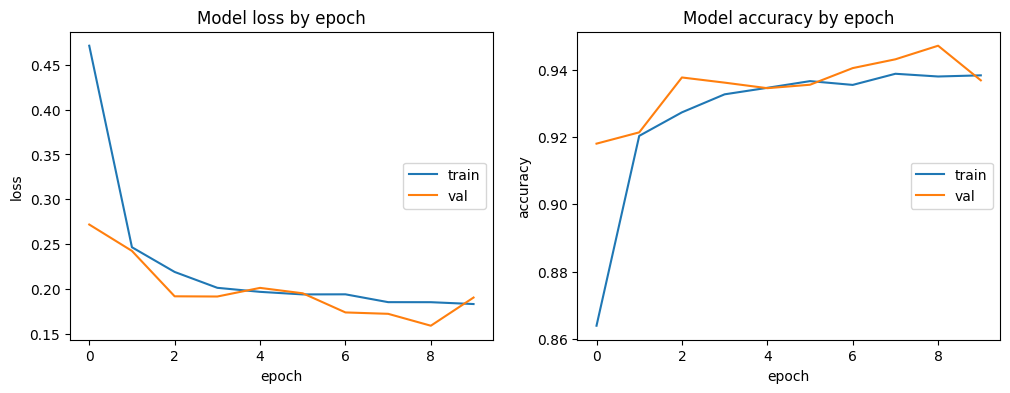

<Figure size 640x480 with 0 Axes>

In [31]:
from os import path


plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

plt.savefig(f"{DATE}_model_training_history_int_phase.png")

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       504
           1       0.98      0.98      0.98       497
           2       0.99      0.96      0.98       440
           3       0.92      0.99      0.95       502
           4       1.00      0.99      0.99       454
           5       1.00      0.98      0.99       421
           6       0.95      1.00      0.97       456
           7       0.97      0.79      0.87       410
           8       0.99      1.00      0.99       477
           9       0.85      0.98      0.91       477
          10       1.00      1.00      1.00       465
          11       0.97      0.97      0.97       472
          12       0.97      0.97      0.97       480
          13       0.99      1.00      0.99       430
          14       1.00      1.00      1.00       423
          15       0.98      1.00      0.99       503
          16       0.97      0.98      0.97       459
          17       0.99    

<Axes: >

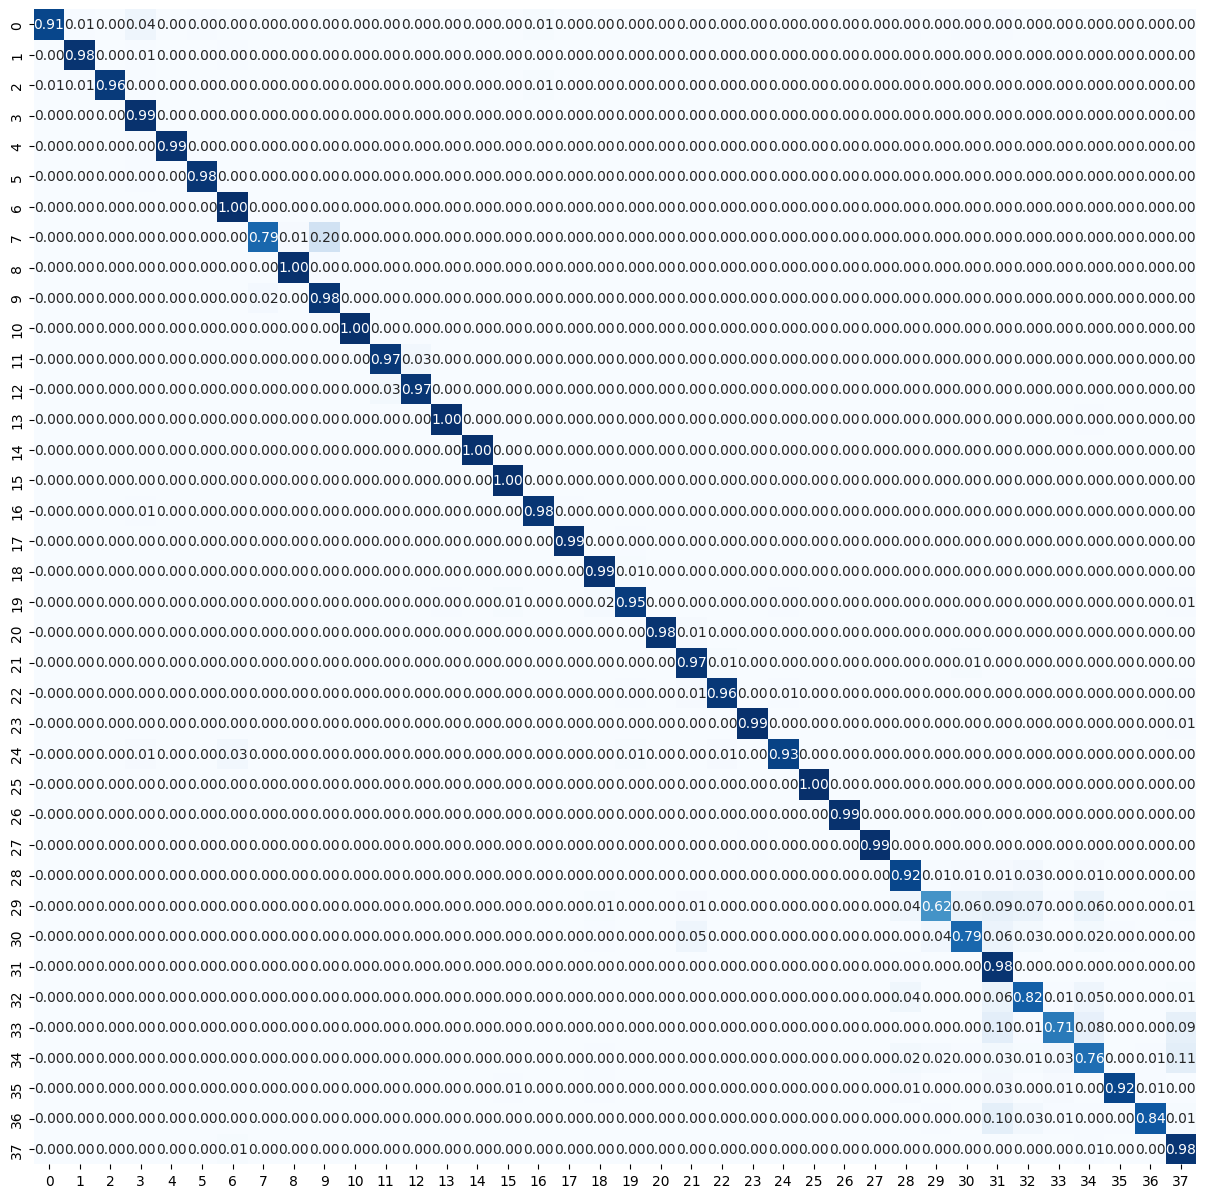

In [32]:
def get_predictions_and_labels(dataset):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        
        preds = model.predict(images, verbose=0)  # Get the model's predictions
        pred_labels.extend(np.argmax(preds, axis=-1))  # Get the predicted labels (argmax)

        true_labels.extend(labels.numpy())  # Get the true labels

    return np.array(true_labels), np.array(pred_labels)

y_true, y_pred = get_predictions_and_labels(validation_dataset)  # Get true labels and predictions from the test dataset

# Display the classification report
print(classification_report(y_true, y_pred))  # Print the classification report (precision, recall, F1-score)

# Display the confusion matrix
plt.figure(figsize=(15, 15))  # Create a large figure for the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')  # Compute the normalized confusion matrix
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt=".2f")  # Plot the confusion matrix as a heatmap


# 5. FINE-TUNING (Train the whole model with a low learning rate)

In [35]:

print("\n--- STARTING FINE-TUNING (UNFREEZING TOP LAYERS) ---")

base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False




import json


DATE = date.today().strftime("%Y_%m_%d")


save_dir = f"/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/"
save_path = os.path.join(save_dir, f"{DATE}_layers_fine_tuned_phase_model.json")

layer_info = []
for layer in model.layers:
    info = {
        "name": layer.name,
        "class": layer.__class__.__name__,
        "params": layer.count_params()
    }

    # Optional: output_shape prüfen
    try:
        info["output_shape"] = str(layer.output.shape)
    except AttributeError:
        info["output_shape"] = "n/a"

    # Sicher prüfen auf activation
    try:
        info["activation"] = layer.activation.__name__
    except AttributeError:
        info["activation"] = "n/a"

    layer_info.append(info)

with open("first_model_layers.json", "w") as f:
    json.dump(layer_info, f, indent=2)

print(f"Summary gespeichert unter: {save_path}")

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)






model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- MODEL SUMMARY (after unfreezing for fine-tuning) ---")
model.summary()

total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
history_fine_tune = model.fit(train_dataset,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              validation_data=validation_dataset,
                            callbacks=[tensorboard_callback, cm_callback])

print("\n--- TRAINING COMPLETE ---")


--- STARTING FINE-TUNING (UNFREEZING TOP LAYERS) ---
Number of layers in the base model:  154
Summary gespeichert unter: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/2025_07_31_layers_fine_tuned_phase_model.json

--- MODEL SUMMARY (after unfreezing for fine-tuning) ---


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 10/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 85s 154ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 777s 352ms/step - accuracy: 0.7989 - loss: 0.9286 - val_accuracy: 0.9402 - val_loss: 0.1868
Epoch 11/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 86s 156ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 779s 355ms/step - accuracy: 0.9273 - loss: 0.2190 - val_accuracy: 0.9520 - val_loss: 0.1429
Epoch 12/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 752s 343ms/step - accuracy: 0.9486 - loss: 0.1523 - val_accuracy: 0.9623 - val_loss: 0.1111
Epoch 13/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 81s 147ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 741s 337ms/step - accuracy: 0.9602 - loss: 0.1159 - val_accuracy: 0.9708 - val_loss: 0.0843
Epoch 14/20
  1/550 ━━━━━━━━━━━━━━━━━━━━ 1:39 181ms/step67ms/step - accuracy: 0.9674 - loss: 0.0937

2025-07-31 17:59:54.069341: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


550/550 ━━━━━━━━━━━━━━━━━━━━ 84s 152ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 756s 344ms/step - accuracy: 0.9674 - loss: 0.0937 - val_accuracy: 0.9716 - val_loss: 0.0778
Epoch 15/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 81s 147ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 748s 341ms/step - accuracy: 0.9738 - loss: 0.0770 - val_accuracy: 0.9788 - val_loss: 0.0618
Epoch 16/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 83s 150ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 756s 344ms/step - accuracy: 0.9779 - loss: 0.0629 - val_accuracy: 0.9807 - val_loss: 0.0562
Epoch 17/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 81s 148ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 747s 340ms/step - accuracy: 0.9813 - loss: 0.0544 - val_accuracy: 0.9824 - val_loss: 0.0517
Epoch 18/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 84s 154ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 758s 345ms/step - accuracy: 0.9829 - loss: 0.0493 - val_accuracy: 0.9816 - val_loss: 0.0541
Epoch 19/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 766s 349ms/step - accuracy: 0.

In [36]:
#Save the model


DATE = date.today().strftime("%Y_%m_%d")
model_path = f"/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/{DATE}_plant_classifier_fine_tuned__model.keras"
model.save(model_path)

with open(f"{DATE}_model_history_fine_tune_phase.json", "w") as f:
    json.dump(history_fine_tune.history, f)

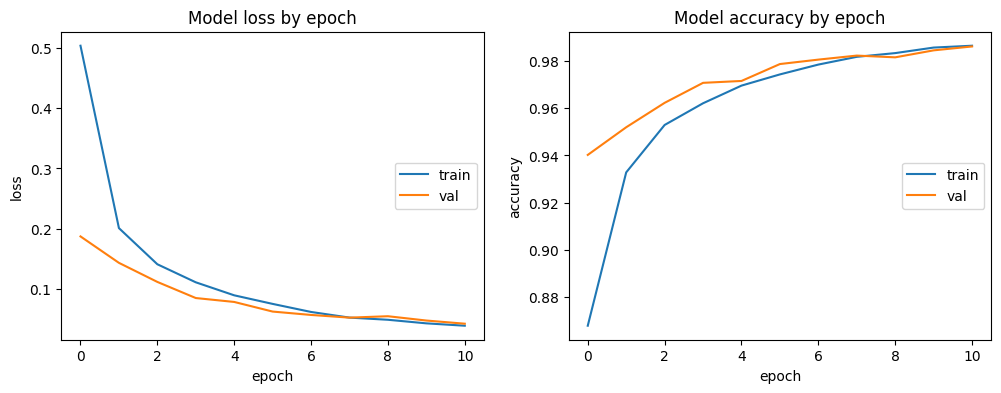

<Figure size 640x480 with 0 Axes>

In [37]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_fine_tune.history['accuracy'])
plt.plot(history_fine_tune.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()
plt.savefig(f"{DATE}_model_training_history_fine_tune_phase.png")

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       504
           1       1.00      1.00      1.00       497
           2       1.00      1.00      1.00       440
           3       1.00      1.00      1.00       502
           4       0.99      1.00      1.00       454
           5       1.00      0.99      1.00       421
           6       1.00      1.00      1.00       456
           7       0.97      0.92      0.95       410
           8       0.99      1.00      1.00       477
           9       0.93      0.97      0.95       477
          10       1.00      1.00      1.00       465
          11       0.99      0.99      0.99       472
          12       0.99      1.00      0.99       480
          13       1.00      1.00      1.00       430
          14       1.00      1.00      1.00       423
          15       1.00      0.99      1.00       503
          16       1.00      0.99      1.00       459
          17       1.00    

<Axes: >

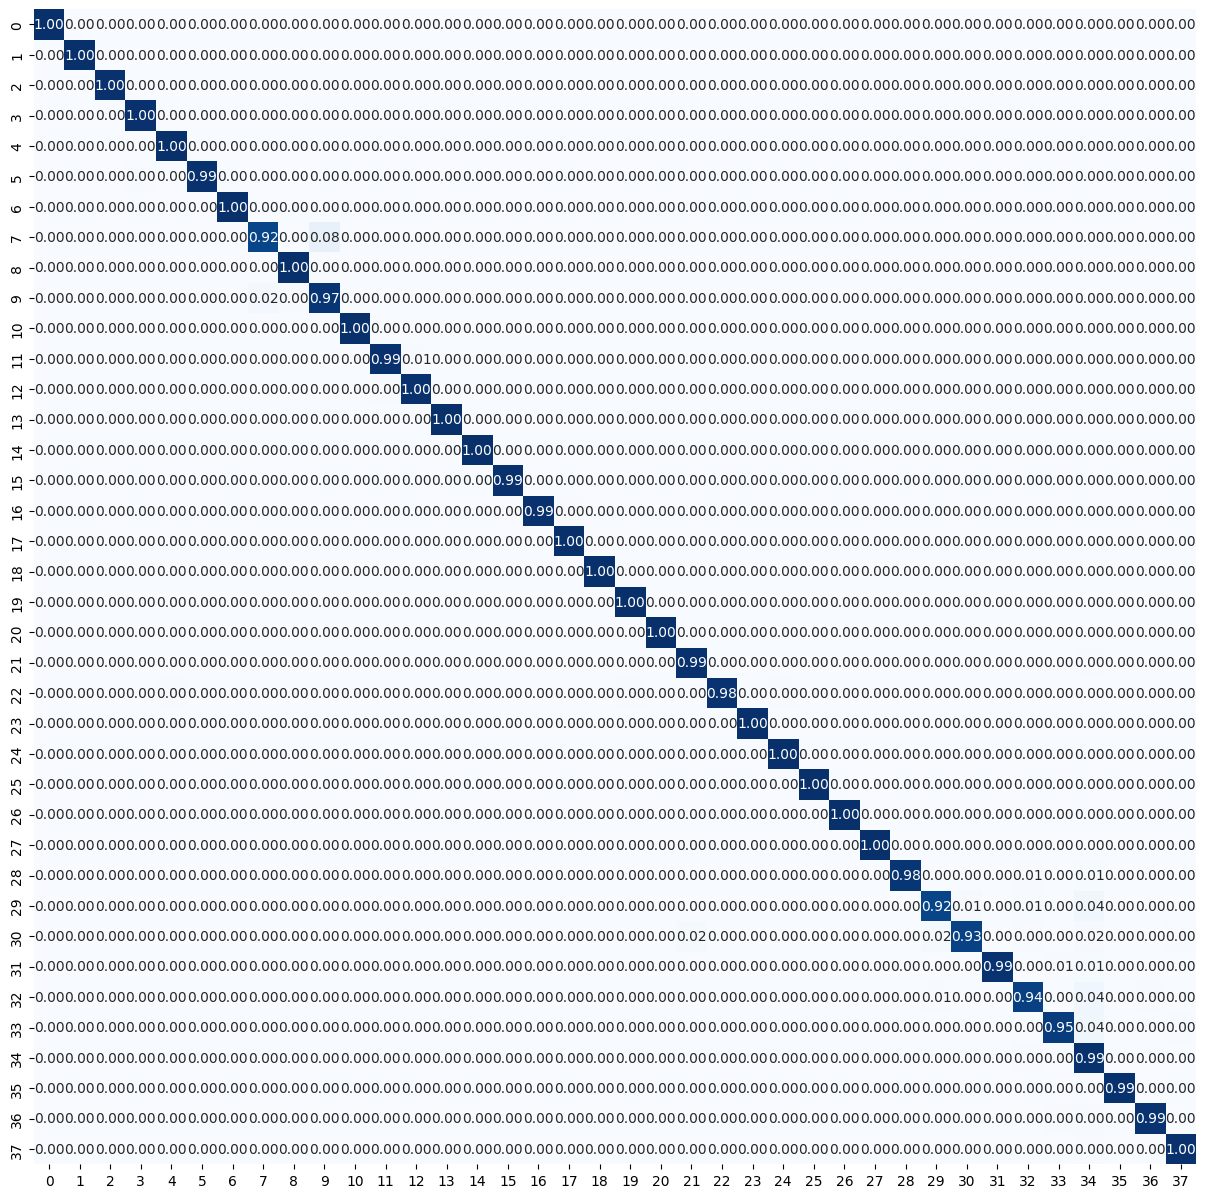

In [19]:
def get_predictions_and_labels(dataset):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        
        preds = model.predict(images, verbose=0)  # Get the model's predictions
        pred_labels.extend(np.argmax(preds, axis=-1))  # Get the predicted labels (argmax)

        true_labels.extend(labels.numpy())  # Get the true labels

    return np.array(true_labels), np.array(pred_labels)

y_true, y_pred = get_predictions_and_labels(validation_dataset)  # Get true labels and predictions from the test dataset

# Display the classification report
print(classification_report(y_true, y_pred))  # Print the classification report (precision, recall, F1-score)

# Display the confusion matrix
plt.figure(figsize=(15, 15))  # Create a large figure for the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')  # Compute the normalized confusion matrix
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt=".2f")  # Plot the confusion matrix as a heatmap


In [27]:
import datetime
from datetime import date
DATE = date.today().strftime("%Y_%m_%d")
model_path = f"/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/{DATE}_plant_classifier_fine_tuned.keras"

# Save the model
model.save(model_path)
model.save

print(f"Model saved to {model_path}")

Model saved to /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/2025_07_10_plant_classifier_fine_tuned.keras
